# Bike dataset analysis

## Domain <br>

#### Dataset
Bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions, precipitation, day of week, season, hour of the day, etc. can affect the rental behaviors. 
The core data set is related to  the two-year historical log corresponding to years 2011 and 2012 from Capital Bike share system, Washington D.C.<br>
The dataset is available at https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset#

#### Dataset Characteristrics
- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered <br>

#### Associated Technics
1. Multiple linear regression
2. Error rate
3. Cross validation  (kn fold)

## Load data and packages

In [1]:
#load packages
library(dplyr)
library(ggplot2)
library(ggcorrplot)
library(tree)
library(lattice)
library(randomForest)
library(tidyverse)
library(mosaic)
library(leaps)
library(stargazer)
library(DAAG)
library(rattle)
library(rpart.plot)
library(rpart)
library(RColorBrewer)
library(tidyverse)

#Data clean $ massage
bike <- read.csv("day.csv")
bike <- na.omit(bike)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

The following object is masked from ‘package:dplyr’:

    combine

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ randomForest::combine() masks dplyr::combine()
✖ dplyr::filter()         masks stats::filter()
✖ dplyr::lag()            masks stats::lag()
✖ randomForest::margin()  masks ggplot2::margin()
Loading required package: ggformula
Loading required package: ggstance

Attaching package: ‘ggst

# Data cleaning and manuplation

In [2]:
sum(is.na(bike))

[1] 0

In [3]:
dim(bike)

[1] 731  16

In [4]:
bike$mnth <- factor(bike$mnth, levels = 1:12,
                    labels=c('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))


bike$holiday <- factor(bike$holiday, levels = 0:1,
                      labels = c('No_Holiday','Hoiliday'))


bike$season <- factor(bike$season, levels = 1:4,
                      labels = c('Spring','Summer','Fall','Winter'))

bike$weekday <-factor(bike$weekday, levels = 0:6,
                      labels = c('Sun','Mon','Tue','Wed','Thur','Fri','Sat'))

bike$workingday <-factor(bike$workingday, levels = 0:1,
                         labels = c('No_work','work'))

bike$yr <- factor(bike$yr, levels = 0:1,
                  labels = c('2011','2012'))

bike$weathersit <-factor(bike$weathersit, levels = 1:4,
                         labels = c('Clear','Cloudy','L_rain_snow','H_rain_snow'))

#I converted normalized values into denormallize valus because the normalized valuses are very low.
bike$temp <- bike$temp * 41

bike$hum <- bike$hum * 100

bike$atemp <- bike$atemp * 50

bike$windspeed <- bike$windspeed*67

In [5]:
sapply(bike, class)
glimpse(bike)
summary(bike)

instant     dteday     season         yr       mnth    holiday    weekday 
 "integer"   "factor"   "factor"   "factor"   "factor"   "factor"   "factor" 
workingday weathersit       temp      atemp        hum  windspeed     casual 
  "factor"   "factor"  "numeric"  "numeric"  "numeric"  "numeric"  "integer" 
registered        cnt 
 "integer"  "integer"

Observations: 731
Variables: 16
$ instant    <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1...
$ dteday     <fct> 2011-01-01, 2011-01-02, 2011-01-03, 2011-01-04, 2011-01-...
$ season     <fct> Spring, Spring, Spring, Spring, Spring, Spring, Spring, ...
$ yr         <fct> 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 20...
$ mnth       <fct> Jan, Jan, Jan, Jan, Jan, Jan, Jan, Jan, Jan, Jan, Jan, J...
$ holiday    <fct> No_Holiday, No_Holiday, No_Holiday, No_Holiday, No_Holid...
$ weekday    <fct> Sat, Sun, Mon, Tue, Wed, Thur, Fri, Sat, Sun, Mon, Tue, ...
$ workingday <fct> No_work, No_work, work, work, work, work, work, No_work,...
$ weathersit <fct> Cloudy, Cloudy, Clear, Clear, Clear, Clear, Cloudy, Clou...
$ temp       <dbl> 14.110847, 14.902598, 8.050924, 8.200000, 9.305237, 8.37...
$ atemp      <dbl> 18.181250, 17.686950, 9.470250, 10.606100, 11.463500, 11...
$ hum        <dbl> 80.5833, 69.6087, 43.7273, 59.0435, 43.6957, 51.8261, 49...
$ windspeed  <dbl> 1

    instant             dteday       season       yr           mnth    
 Min.   :  1.0   2011-01-01:  1   Spring:181   2011:365   Jan    : 62  
 1st Qu.:183.5   2011-01-02:  1   Summer:184   2012:366   Mar    : 62  
 Median :366.0   2011-01-03:  1   Fall  :188              May    : 62  
 Mean   :366.0   2011-01-04:  1   Winter:178              Jul    : 62  
 3rd Qu.:548.5   2011-01-05:  1                           Aug    : 62  
 Max.   :731.0   2011-01-06:  1                           Oct    : 62  
                 (Other)   :725                           (Other):359  
       holiday    weekday      workingday        weathersit       temp       
 No_Holiday:710   Sun :105   No_work:231   Clear      :463   Min.   : 2.424  
 Hoiliday  : 21   Mon :105   work   :500   Cloudy     :247   1st Qu.:13.820  
                  Tue :104                 L_rain_snow: 21   Median :20.432  
                  Wed :104                 H_rain_snow:  0   Mean   :20.311  
                  Thur:104        

# Exploratory Data Analysis

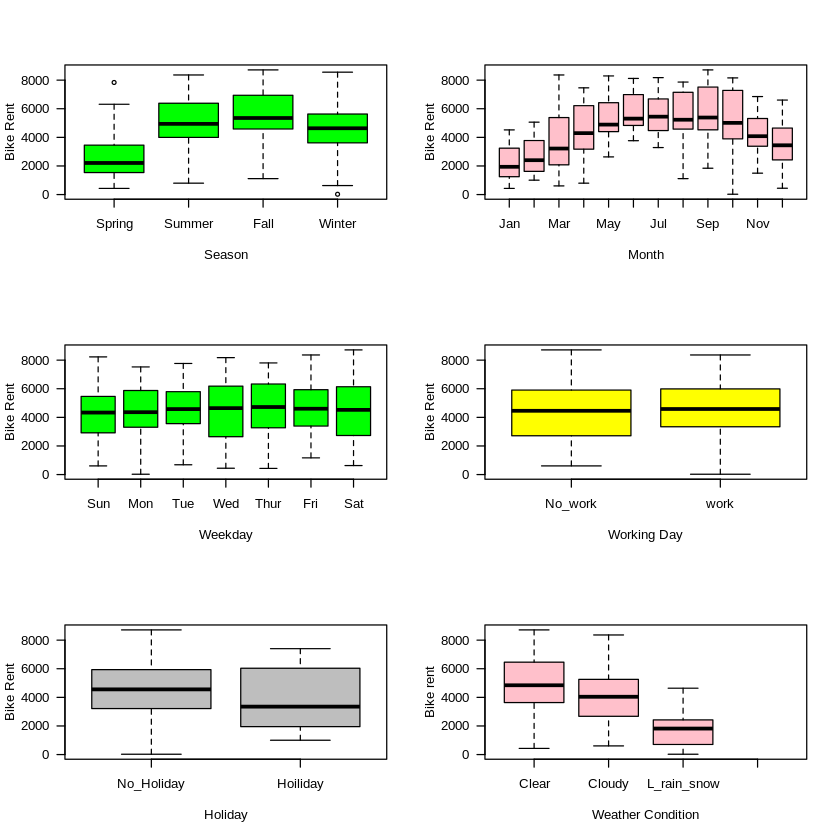

In [6]:
par(mfrow = c(3:2))
with(data = bike,
     plot(season, cnt,
          xlab = "Season",
          ylab = "Bike Rent",
          col = "green", las = 1))
with(data = bike,
     plot(mnth, cnt,
          xlab = "Month",
          ylab = "Bike Rent",
          col = "pink", las = 1))
with(data = bike,
     plot(weekday, cnt,
          xlab = "Weekday",
          ylab = "Bike Rent",
          col = "green", las = 1))
with(data = bike,
     plot(workingday, cnt,
          xlab = "Working Day",
          ylab = "Bike Rent",
          col = "yellow", las = 1))     
with(data = bike,
     plot(holiday, cnt,
          xlab = "Holiday",
          ylab = "Bike Rent",
          col = "grey", las = 1))

plot(bike$weathersit, bike$cnt,
     xlab = "Weather Condition",
     ylab = "Bike rent",
     col = "pink", las = 1)

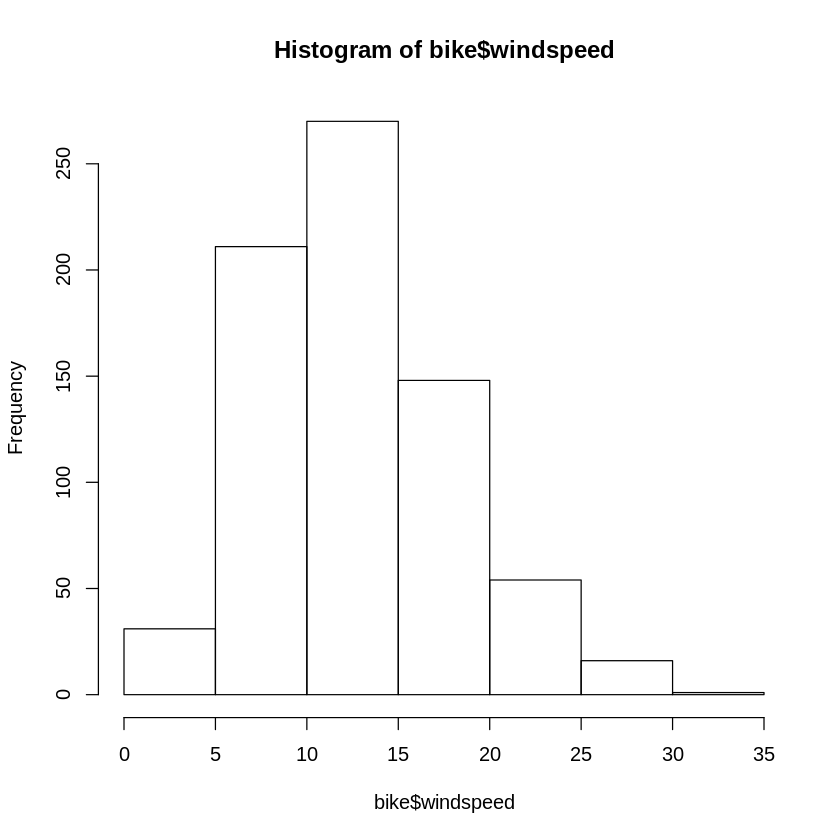

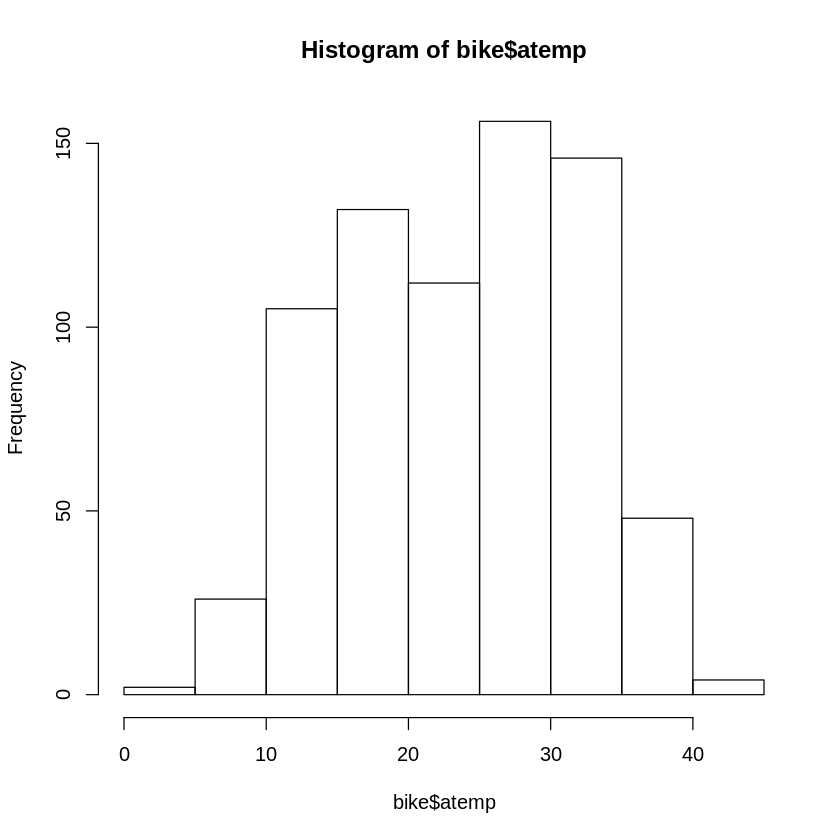

In [13]:
p1 <- hist(bike$windspeed)                   
p2 <- hist(bike$atemp)                 

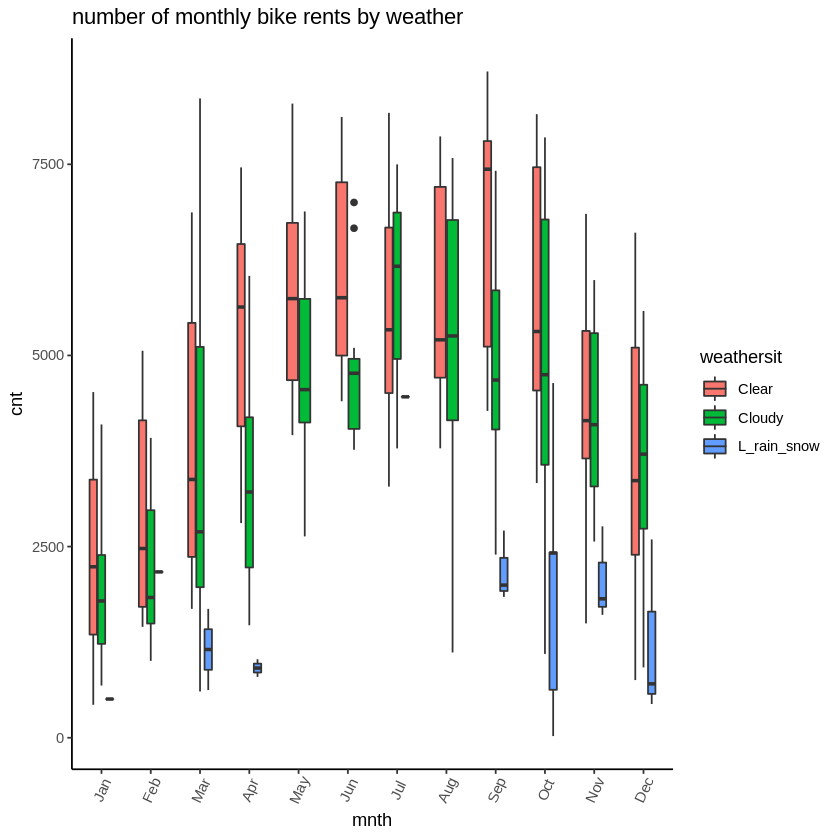

In [14]:
theme_set(theme_classic())
g<- ggplot(bike,aes(mnth,cnt))
g + geom_boxplot(aes(fill=weathersit), width = 0.5) +
  theme(axis.text.x = element_text(angle=65, vjust = 0.6)) +
  labs(title="number of monthly bike rents by weather")

All of these plots shows the relationship between total number of bike rents(cnt) and other variables(Season, month, day of week, weather condition and so on). The last plot shows the total bike rents based on both weather condition and month. As you can see on this chart, bike rentals are affected by weather.

# Linear Model
Since I want to see how the weather condition influnece to the number of bike rents, 
I selected four variables reltaed to weather condition.


In [15]:
myvals <- c('weathersit','atemp','windspeed','cnt')
bike_new <- bike[myvals]

In [16]:
set.seed(1234) #set seed
ran<-sample(x=nrow(bike_new),size=.70*nrow(bike_new))
bike_new_train<-bike_new[ran, ]
bike_new_test<-bike_new[-ran, ]
table(bike_new_train$outcome01)
table(bike_new_test$outcome01)

< table of extent 0 >

< table of extent 0 >

In [17]:
my.model <- {cnt ~ weathersit + atemp + windspeed}
train.model.fit <- lm(my.model, data = bike_new_train)
print(summary(train.model.fit))
bike_new_train$predict_rent <- predict(train.model.fit)
bike_new_test$predict_rent <- predict(train.model.fit, newdata = bike_new_test)


Call:
lm(formula = my.model, data = bike_new_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-3915.1 -1053.1  -128.8  1156.6  3961.2 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            2123.300    292.462   7.260 1.47e-12 ***
weathersitCloudy       -729.200    136.675  -5.335 1.44e-07 ***
weathersitL_rain_snow -2600.671    368.302  -7.061 5.48e-12 ***
atemp                   134.179      8.118  16.528  < 2e-16 ***
windspeed               -36.302     12.655  -2.869  0.00429 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1428 on 506 degrees of freedom
Multiple R-squared:  0.4553,	Adjusted R-squared:  0.4509 
F-statistic: 105.7 on 4 and 506 DF,  p-value: < 2.2e-16



In [18]:
my.model.fit <- lm(my.model, data = bike_new)
print(summary(my.model.fit))

print(anova(my.model.fit))
cat("\n", "Estimated Effect of weather on bike rent: ",
    round(my.model.fit$coefficients[length(my.model.fit$coefficients)],
          digits = 0), "\n", sep = "")


Call:
lm(formula = my.model, data = bike_new)

Residuals:
    Min      1Q  Median      3Q     Max 
-4089.8 -1067.5  -131.1  1044.4  4091.3 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            2001.800    235.015   8.518  < 2e-16 ***
weathersitCloudy       -603.330    112.218  -5.376 1.03e-07 ***
weathersitL_rain_snow -2405.343    318.356  -7.556 1.26e-13 ***
atemp                   138.803      6.586  21.076  < 2e-16 ***
windspeed               -40.476     10.332  -3.917 9.80e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1415 on 726 degrees of freedom
Multiple R-squared:  0.4692,	Adjusted R-squared:  0.4662 
F-statistic: 160.4 on 4 and 726 DF,  p-value: < 2.2e-16

Analysis of Variance Table

Response: cnt
            Df     Sum Sq   Mean Sq F value    Pr(>F)    
weathersit   2  271644573 135822286  67.806 < 2.2e-16 ***
atemp        1  982890398 982890398 490.681 < 2.2e-16 ***
winds

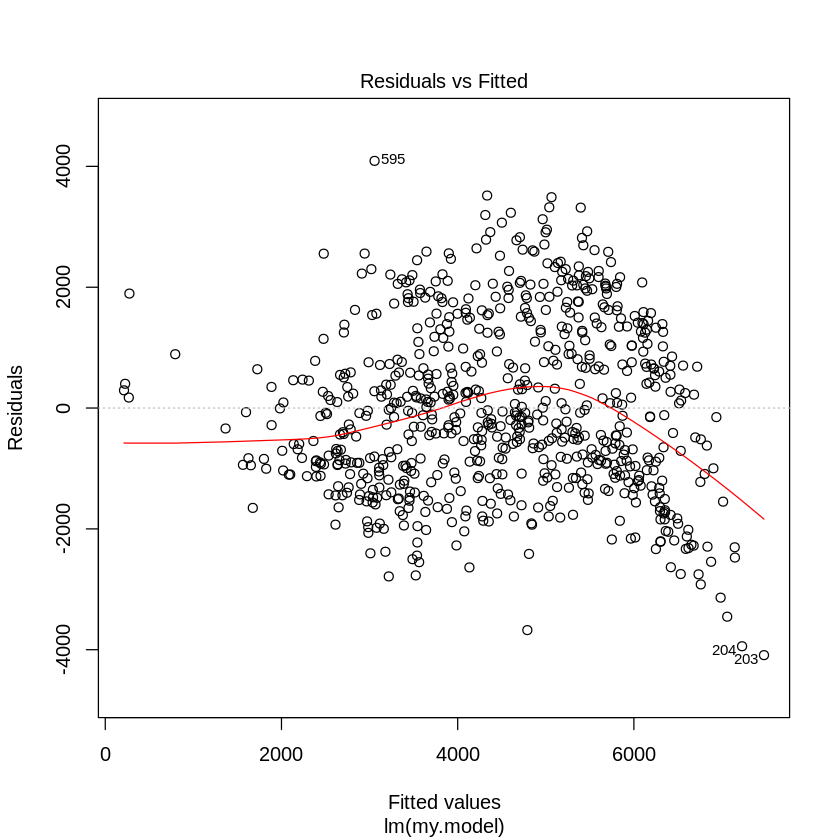

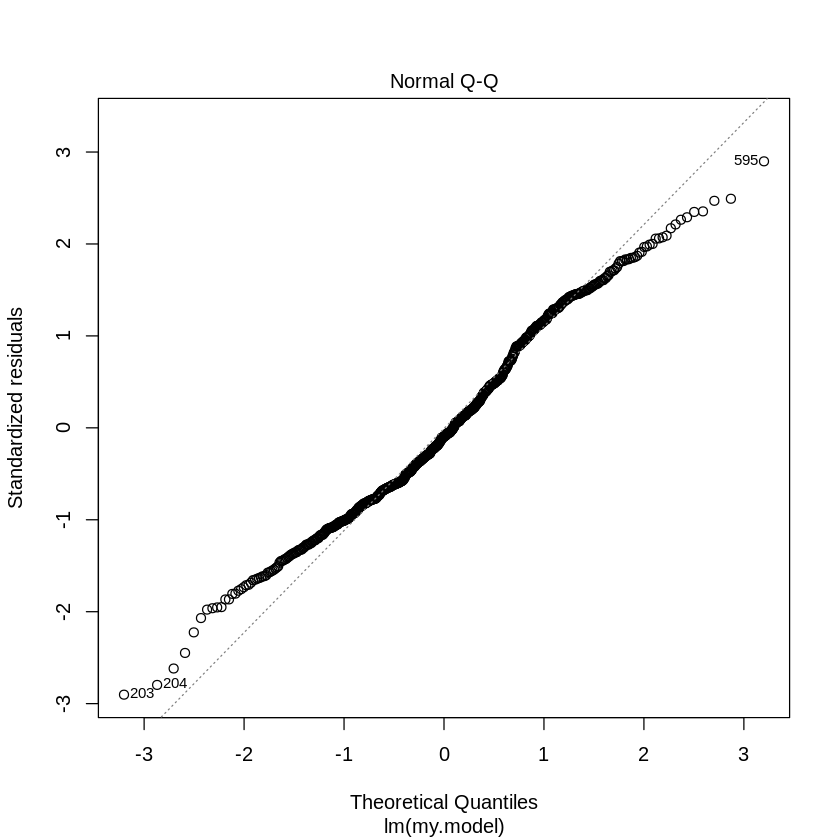

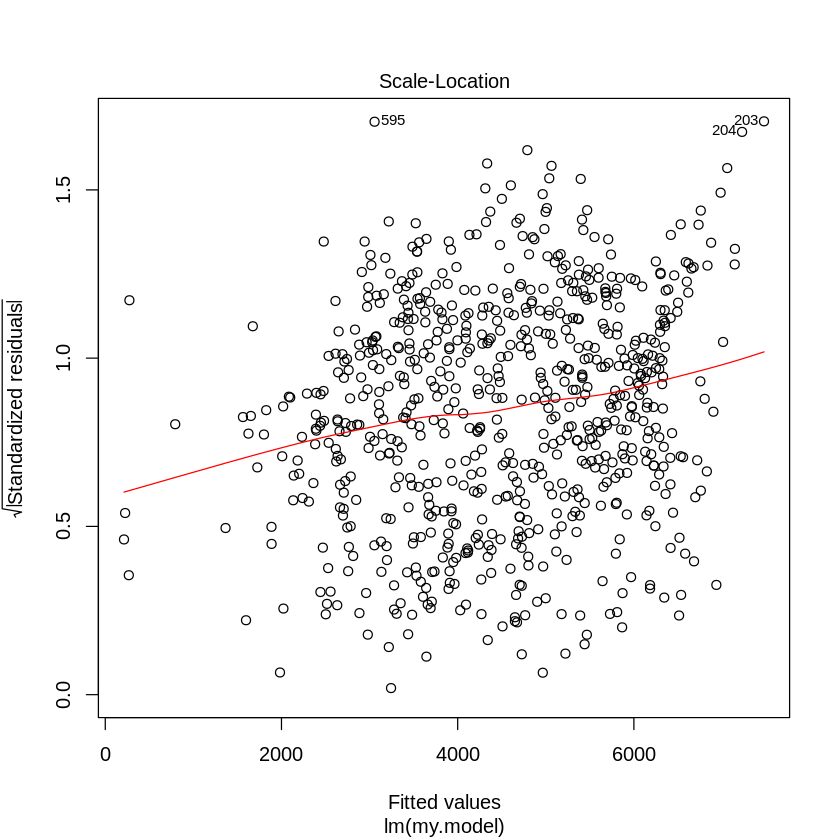

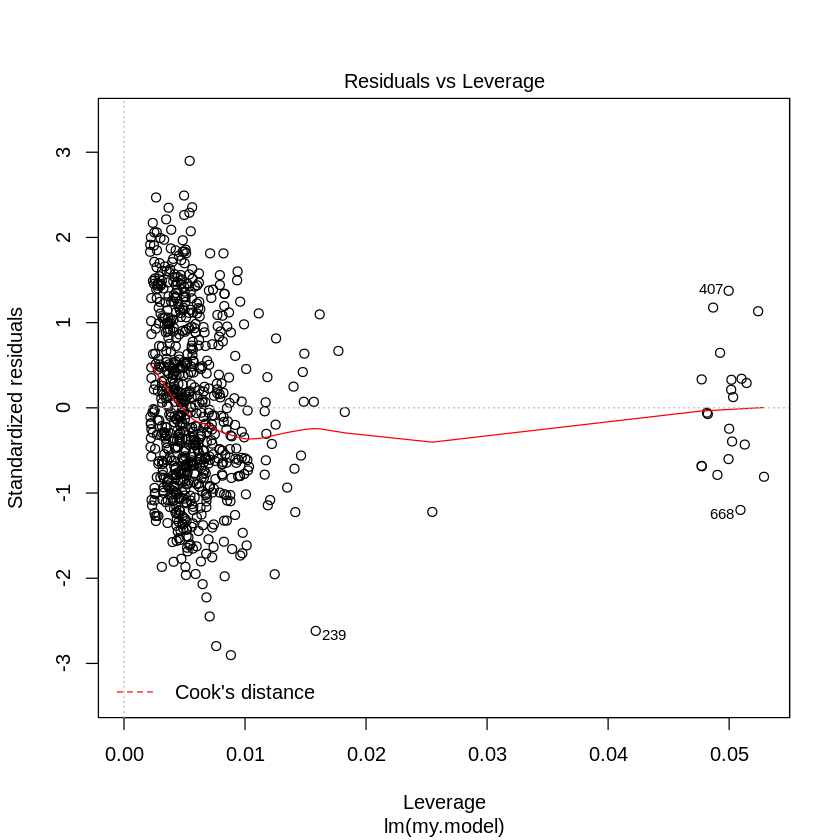

In [20]:
plot(my.model.fit)

In [21]:
bike_new$predicted_value <- predict(my.model.fit, newdata=bike_new, level = 0.95)

# Error rate of my model

In [22]:
#MAE
mae<-sum(abs(bike_new$cnt - bike_new$predicted_value))
rst_mae <- mae/length(bike_new)
rst_mae

#MSE
mse <-sum((bike_new$cnt - bike_new$predicted_value)^2)
rst_mse <- mse/length(bike_new)
rst_mse

#MPE
mpe <- sum((bike_new$cnt - bike_new$predicted_value)/bike_new$cnt)
rst_mpe = mpe/length(bike_new)
rst_mpe

[1] 170525.3

[1] 290852141

[1] -38.51192

# Cross Validation

Analysis of Variance Table

Response: cnt
            Df   Sum Sq  Mean Sq F value  Pr(>F)    
weathersit   2 2.72e+08 1.36e+08    67.8 < 2e-16 ***
atemp        1 9.83e+08 9.83e+08   490.7 < 2e-16 ***
windspeed    1 3.07e+07 3.07e+07    15.3 9.8e-05 ***
Residuals  726 1.45e+09 2.00e+06                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




Warning message in cv.lm(bike_new, my.model, m = 5, dots = FALSE, seed = 1234, plotit = TRUE, :
“

 As there is >1 explanatory variable, cross-validation
 predicted values for a fold are not a linear function
 of corresponding overall predicted values.  Lines that
 are shown for the different folds are approximate
”


fold 1 
Observations in test set: 146 
                2     3     6    15    16    17    22   25    29   31    34
Predicted    3179  2643  3377  2692  3116  2099  2084 2674  3080 2183  2483
cvpred       3170  2751  3510  2754  3221  2183  2262 2750  3207 2265  2588
cnt           801  1349  1606  1248  1204  1000   981 1985  1098 1501  1550
CV residual -2369 -1402 -1904 -1506 -2017 -1183 -1281 -765 -2109 -764 -1038
               37    38    43    46    64    65    67    69    72    75    87
Predicted    3641  3986  3067  2976  3344  3009  3773  1563  3906  3394  3214
cvpred       3734  4100  3169  3044  3323  2969  3867  1631  3924  3392  3302
cnt          1623  1712  1472  1815  2077   605  2133   623  2417  2192  2028
CV residual -2111 -2388 -1697 -1229 -1246 -2364 -1734 -1008 -1507 -1200 -1274
              100   110  121  129  138    139  140  156   171   179  182   183
Predicted    3962  5263 4221 5170 4511 4649.6 5334 5303  5109  6417 6250  6321
cvpred       3949  5208 4209 515

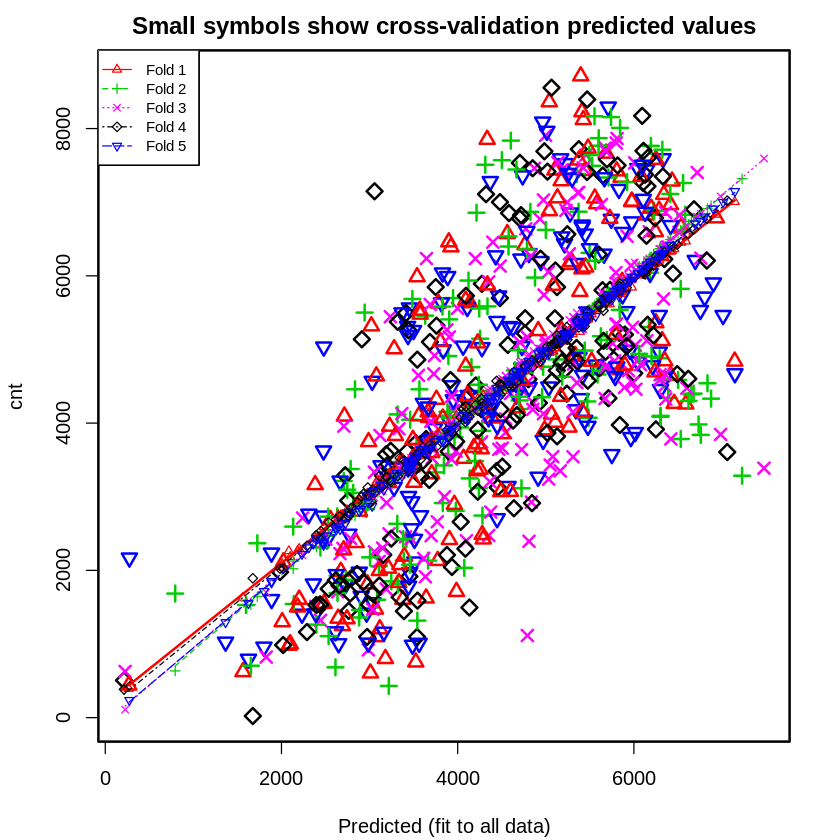

In [23]:
cv.lm(bike_new, my.model, m=5, dots = 
        FALSE, seed=1234, plotit=TRUE, printit=TRUE)

# Conclusion

Based on the regression result, 3 weather variables are significant at sgnificant level 0.001. This means the wheather conditions have effect on the bike rents. However, R-squared value is around 47% which means that my model only explains 46% of the response data.

Additionally, residual plot, MAE, MSE and Knfold validation indicates that there are residual, and also it has pattern. Therefore, the linear model doesn't fit the data well.

- Futher work :
Explore the regression model with a different variable set.